We consider the case when the second group is much smaller than the first one. 

In [19]:
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import eig

import os
import pandas as pd

import random

from scipy.sparse.csgraph import laplacian
from scipy.stats import bernoulli

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans 

import time


from simulate import *

In [95]:
?os.mkdir

In [69]:

job_id = 0
n1 = 500
n2 = 500
n = n1 + n2
m = 30
N = n + m
r = 2
p1 = 0.29
p2 = 0.2
q = 0.11
degree_correct = True

In [97]:
output_dir = "figures/" + "imbalanced" + str(job_id) + "/"
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [29]:
# Generate group labels, group "2" is outlier
phi_ordered_o = [0] * int(n1) + [1] * int(n2) + [2] * int(m)
#phi_o = [i for i in random.sample(phi_ordered_o, n)]
phi_o = phi_ordered_o

In [30]:
# Generate connectivity matrix B
B_in = np.zeros((n, n))
for i in range(n):
    for j in range(i):
        if phi_o[i] == phi_o[j] and phi_o[i] == 0:
            B_in[i, j] = p1
        elif phi_o[i] == phi_o[j] and phi_o[i] == 1:
            B_in[i, j] = p2
        else:
            B_in[i, j] = q
B_in = B_in + B_in.transpose()

In [31]:
K = conn2adj(B_in)

# Generate adjacdncy matrix W for outliers
B_out = np.full((m, m), .7) - .7 * np.eye(m)

W = conn2adj(B_out)

# Generate Z
beta = np.random.uniform(low =  0, high= 1, size = n)
beta = beta ** 2
EZ = np.tile(beta, (m, 1)).transpose()

Z = np.zeros((n, m))
for idx, z in np.ndenumerate(EZ):
    #print(idx, z)
    Z[idx] = bernoulli.rvs(size = 1, p = z)
    
    
# Combine K, Z and W to be A
A_combined = np.concatenate((K, Z), axis = 1)
bottom = np.concatenate((Z.transpose(), W), axis = 1)
A_combined = np.concatenate((A_combined, bottom), axis = 0)

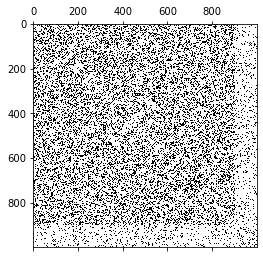

In [32]:
plt.matshow(K, cmap = plt.cm.binary)
plt.savefig(output_dir + 'K.png')

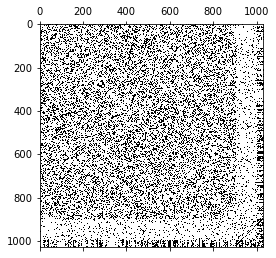

In [33]:
plt.matshow(A_combined, cmap = plt.cm.binary)
plt.savefig(output_dir + 'A.png')

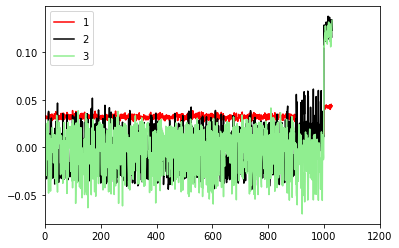

In [37]:
# (fig2, right bottom)
A_combined_values, A_combined_vectors = eig(A_combined)

A_combined_val1, A_combined_vec1 = find_j_eigenvec(A_combined_values, A_combined_vectors, j = 1)
A_combined_val2, A_combined_vec2 = find_j_eigenvec(A_combined_values, A_combined_vectors, j = 2)
A_combined_val3, A_combined_vec3 = find_j_eigenvec(A_combined_values, A_combined_vectors, j = 3)
A_combined_vec_list = [A_combined_vec1, A_combined_vec2, A_combined_vec3]

for i, color in enumerate(['red', 'black',  'lightgreen'], start = 1):
    plt.plot(np.arange(n + m).tolist(), A_combined_vec_list[i - 1], color = color, label='${i}$'.format(i = i))
    
plt.legend(loc = 'best')
plt.xlim([0,1200])
plt.savefig(output_dir + 'A_eigen3.png')
plt.show()


# Algorithm

In [41]:
Z = 0
Lambda = 0
rho = 1
max_iter = 100
alpha = 0
lam = .11

In [45]:
if degree_correct:
    D = np.zeros((N, N))
    np.fill_diagonal(D, np.diag(A_combined @ np.full((N, N), 1)) / N)
    E = - (np.eye(N) - D) ** (1 / 2) @ A_combined @ (np.eye(N) - D) ** (1 / 2) +  D ** (1 / 2) @ (np.full((N, N), 1) - np.eye(N) - A_combined) @ D ** (1 / 2)
else:
    E = alpha * np.eye(N) - (1 - lam) * A_combined + lam * (np.full((N, N), 1) - np.eye(N) - A_combined)

In [46]:
k = 0
time.start = time.time()
while k < max_iter:
    if k % 10 == 0:
        print("k = ", k, time.time() - time.start, "\n")
    # 1. Update Y ========
    
    X = Z - Lambda - E / rho
    X_values, V = eig(X)

    X_values_plus = X_values * (X_values > 0)
    Sigma_plus = np.zeros((N, N))
    np.fill_diagonal(Sigma_plus, X_values_plus)

    X_plus = V @ Sigma_plus @ V.transpose()
    Y = X_plus
    
    # 2. Update Z ========
    inside = (Y + Lambda) * (Y + Lambda > 0)
    Z = inside * (inside > 1) +  np.full((N, N), 1) * (inside <= 1)
    
    # 3. Update Lambda ========
    Lambda = Lambda + (Y - Z)
    
    k += 1

k =  0 0.0001862049102783203 



KeyboardInterrupt: 

In [47]:
Xhat = Y
Xhat_normalized = normalize(Xhat, axis = 1, norm = 'l2')

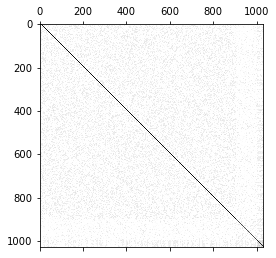

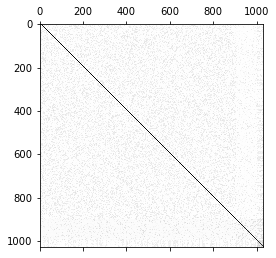

In [48]:
plt.matshow(Xhat, cmap = plt.cm.binary)
plt.savefig(output_dir + 'Xhat.png')
plt.matshow(Xhat_normalized, cmap = plt.cm.binary)
plt.savefig(output_dir + 'Xhat_normalized.png')

In [62]:
yhat_list = []
mis_rates = []

mis_rates_inlier = []
for seed in range(100):
    kmeans = KMeans(n_clusters = 2, random_state = seed).fit(Xhat)
    yhat = kmeans.labels_
    yhat_list = yhat_list + [yhat]
    
    mis_rate = cal_mis_rate(phi_o, yhat)
    mis_rates = mis_rates + [mis_rate]
    
    mis_rate_inlier = cal_mis_rate(phi_o[:n], yhat[:n])
    mis_rates_inlier = mis_rates_inlier + [mis_rate_inlier]
    
   # print("seed = ", seed, "mis rate inlier = ", mis_rate_inlier,
   #       ", mis rate = ", mis_rate, "\n")
print("job=",job_id,", avg mis rate = ", np.mean(mis_rates_inlier))

job= 0 , avg mis rate =  0.24792999999999998


In [68]:
# save results
pd.DataFrame({"rate": mis_rates_inlier}).to_csv(output_dir + "rate" + str(job_id) + ".csv")

np.save(output_dir + 'A_combined.npy', A_combined)
np.save(output_dir + 'X.npy', X)
np.save(output_dir + 'Xhat.npy', Xhat)
np.save(output_dir + 'Xhat_normalized.npy', Xhat_normalized)